In [5]:
# General imports
import os
import random
import math
import itertools
import pandas as pd
from tqdm import tqdm
import numpy as np
from datasets import load_metric

# pytorch imports
import torch
torch.backends.cuda.matmul.allow_tf32 = True

# Transformer tokenizer imports
from transformers import BertTokenizerFast

# Transformers data collator
from transformers.data.data_collator import DataCollatorForTokenClassification

# Transformers Bert model
from transformers import AutoModelForTokenClassification, BertForPreTraining, BertConfig, TrainingArguments, Trainer, EarlyStoppingCallback

2022-05-12 17:21:06.826893: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
`fused_weight_gradient_mlp_cuda` module not found. gradient accumulation fusion with weight gradient computation disabled.


In [6]:
from_scratch = False

MAX_SEQ_LEN = 512
LEARNING_RATE = 0.00001
NUM_TRAIN_EPOCHS = 20
PER_DEVICE_TRAIN_BATCH_SIZE = 32
PER_DEVICE_EVAL_BATCH_SIZE = 32
DATA_LOADER_NUM_WORKERS = 4
PATIENCE = 3

BXSMAL="bert_extra_small"
BSMAL="bert_small"
BNORM="bert_normal"
BLARG="bert_larg"

MODEL=BNORM

if MODEL == BXSMAL:
    MAX_SEQ_LEN = 512
    MAX_POSITION_EMBEDDINGS = 514
    HIDDEN_SIZE = 128
    INTERMEDIATE_SIZE = 128
    NUM_ATTENTION_HEADS = 8
    NUM_HIDDEN_LAYERS = 12
    TYPE_VOCAB_SIZE = 2
    
if MODEL == BSMAL:
    MAX_POSITION_EMBEDDINGS = 514
    HIDDEN_SIZE = 512
    INTERMEDIATE_SIZE = 2048
    NUM_ATTENTION_HEADS = 8
    NUM_HIDDEN_LAYERS = 12
    TYPE_VOCAB_SIZE = 2
    
if MODEL == BNORM:
    MAX_POSITION_EMBEDDINGS = 514
    HIDDEN_SIZE = 768
    INTERMEDIATE_SIZE = 3072
    NUM_ATTENTION_HEADS = 12
    NUM_HIDDEN_LAYERS = 12
    TYPE_VOCAB_SIZE = 2    
    
if MODEL == BLARG:
    MAX_POSITION_EMBEDDINGS = 514
    HIDDEN_SIZE = 1024
    INTERMEDIATE_SIZE = 4096
    NUM_ATTENTION_HEADS = 16
    NUM_HIDDEN_LAYERS = 24
    TYPE_VOCAB_SIZE = 2
    
# GPU settings
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["NVIDIA_VISIBLE_DEVICES"] = "0"

In [7]:
task = "token_classification"


base_path = "../../"
prt_model = os.path.join(base_path, "models", "pretraining_model", "checkpoint-67246")
train_path = os.path.join(base_path, "dataset", "finetuning_dataset", "strand_recovery", "train_strand_recovery.csv")
val_path = os.path.join(base_path, "dataset", "finetuning_dataset", "strand_recovery", "val_strand_recovery.csv")
tokenizer_path = os.path.join(base_path, "tokenizer")

model_name =  f"BinBert_strand_recovery"
output_dir = model_path = os.path.join(base_path, "models", "finetuned_models", "strand_recovery", model_name)

In [8]:
def load_tokenizer(tokenizer_path):
    # load tokenizer from dict
    tokenizer =  BertTokenizerFast.from_pretrained(tokenizer_path)
    return tokenizer

In [9]:
import json

def parse_block(b_ins, strands_indices):
    
    b_ins = b_ins.split(" NEXT_I ")
    strands_indices = json.loads(strands_indices)
    
    item = dict.fromkeys(['tokens', 'ner_tags'], None)
    
    last_ins_idx = strands_indices[-1]
    
    sep = "[SEP]"
    left_piece = b_ins[:last_ins_idx]
    central_piece = [sep, b_ins[last_ins_idx], sep]
    right_piece = b_ins[last_ins_idx+1:]

    item["tokens"] = left_piece + central_piece + right_piece
    item["ner_tags"] = []
    for i, ins in enumerate(item["tokens"]):
        # after putting "SEP" token, last ins idx is increased by 1
        if i == last_ins_idx + 1:
            item["ner_tags"].append(-100)
        elif ins == sep:
            item["ner_tags"].append(-100)
        elif i in strands_indices:
            item["ner_tags"].append(1)
        else:
            item["ner_tags"].append(0)
    
    if len(item["tokens"]) != len(item["ner_tags"]):
        print("ASSERT triggered")
        print(b_ins)
        print(strands)
        print(item)
        return None
    
    return item

In [10]:
class AsmToSymbolicDataset(torch.utils.data.Dataset):

    def __init__(self, dataset_path, tokenizer, task):
        
        self.data_store = []
        df = pd.read_csv(dataset_path, sep="\t").fillna('')
        #df["instr_len"] = df["ot_instructions"].apply(lambda x: len(x.split("NEXT_I")))
        #df = df[df["instr_len"]>=10]
        
        if task == "token_classification":
            self.samples = df[["ot_instructions", "strand_indices"]]
        else:
            raise Exception(f"{task} is not a valid task")
        
        self.tokenizer = tokenizer
            
        self.__init_structures()
         
    def __init_structures(self):
        
        for b_ins, strands_indices in tqdm(self.samples.values):
            
            example = parse_block(b_ins, strands_indices)
            if example is None: continue
            
            #print(examples)
            #print()
            
            
            tokenized_example = self.tokenizer(text=example["tokens"], truncation=True, max_length=MAX_SEQ_LEN, is_split_into_words=True)
            #print(tokenized_example)
            #print()
            
            word_ids = tokenized_example.word_ids()
            #print(word_ids)
            #print()
            #print(tokenizer.convert_ids_to_tokens(tokenized_example["input_ids"]))
            #print()

            previous_word_idx = None
            label_ids = []
            for word_idx in word_ids:
                if word_idx is None:
                    label_ids.append(-100)
                elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                    label_ids.append(example["ner_tags"][word_idx])
                else:
                    label_ids.append(-100)
                previous_word_idx = word_idx

            tokenized_example["labels"] = label_ids
            #print(tokenized_example)
            #print()
            self.data_store.append(tokenized_example)
            
        random.shuffle(self.data_store)
                
    def __len__(self) -> int:
        return len(self.data_store)

    def __getitem__(self, idx: int) -> torch.Tensor:
        return self.data_store[idx]
    
    def save_to_file(self,save_file):
        torch.save(self.data_store, save_file)

In [23]:
tokenizer = load_tokenizer(tokenizer_path)
train_dataset = AsmToSymbolicDataset(train_path, tokenizer, task)
val_dataset = AsmToSymbolicDataset(val_path, tokenizer, task)

Didn't find file /home/jovyan/work/olivetree/final_for_paper/tokenizer/added_tokens.json. We won't load it.
loading file /home/jovyan/work/olivetree/final_for_paper/tokenizer/vocab.txt
loading file /home/jovyan/work/olivetree/final_for_paper/tokenizer/tokenizer.json
loading file None
loading file /home/jovyan/work/olivetree/final_for_paper/tokenizer/special_tokens_map.json
loading file /home/jovyan/work/olivetree/final_for_paper/tokenizer/tokenizer_config.json
100%|██████████| 926/926 [00:00<00:00, 2132.71it/s]


In [24]:
if not from_scratch:
    print("Not from scratch")
    model = AutoModelForTokenClassification.from_pretrained(prt_model, num_labels=2)
else:
    print("From scratch")
    config = BertConfig(
                vocab_size = len(tokenizer.vocab),
                max_position_embeddings = MAX_POSITION_EMBEDDINGS,
                hidden_size = HIDDEN_SIZE,
                intermediate_size = INTERMEDIATE_SIZE,
                num_attention_heads = NUM_ATTENTION_HEADS,
                num_hidden_layers = NUM_HIDDEN_LAYERS,
                type_vocab_size = TYPE_VOCAB_SIZE
    )
    config.num_labels = 2
    model = AutoModelForTokenClassification.from_config(config)

loading configuration file /home/jovyan/work/olivetree/final_for_paper/models/next_sentence_prediction_bert_normal_mask30/checkpoint-67246/config.json
Model config BertConfig {
  "_name_or_path": "/home/jovyan/work/olivetree/final_for_paper/models/next_sentence_prediction_bert_normal_mask30/checkpoint-67246",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 7814
}

loading weights file /home/jovyan/work/olivetree/final_for_paper/models/next_sentence_prediction_be

Not from scratch


Some weights of the model checkpoint at /home/jovyan/work/olivetree/final_for_paper/models/next_sentence_prediction_bert_normal_mask30/checkpoint-67246 were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceC

In [25]:
training_args = TrainingArguments(
                    output_dir = output_dir,
                    overwrite_output_dir = True,
                    num_train_epochs = NUM_TRAIN_EPOCHS,
                    learning_rate = LEARNING_RATE,
                    per_device_train_batch_size = PER_DEVICE_TRAIN_BATCH_SIZE,
                    save_strategy = 'epoch',
                    #save_steps = 1000,
                    save_total_limit = 1,
                    logging_strategy = 'epoch',
                    #logging_steps = 50,
                    # prediction_loss_only = True,
                    #fp16=True if not from_scratch else False,
                    load_best_model_at_end = True,
                    do_eval = True,
                    evaluation_strategy = 'epoch',
                    #eval_steps = 50,
                    metric_for_best_model = 'eval_balanced_accuracy',
                    per_device_eval_batch_size = PER_DEVICE_EVAL_BATCH_SIZE,
                    dataloader_num_workers = DATA_LOADER_NUM_WORKERS)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [26]:
collator = DataCollatorForTokenClassification(tokenizer, padding=True)

In [27]:
# accuracy = load_metric("accuracy")

In [28]:
from sklearn.metrics import classification_report, balanced_accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1).flatten()
    references = labels.flatten()
    condition = references != -100
    
    dict_res = dict()
    report = classification_report(references[condition], predictions[condition], labels=[0, 1], output_dict=True)
    dict_res["accuracy"] = report["accuracy"]
    for label in ['0', '1']:
        for measure in ["precision", "recall", "f1-score"]:
            dict_res[f"{label}-{measure}"] = report[label][measure]
    
    dict_res["balanced_accuracy"] = balanced_accuracy_score(references[condition], predictions[condition])
            
    return dict_res

In [29]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator = collator,
    compute_metrics=compute_metrics,
    #callbacks = [EarlyStoppingCallback(early_stopping_patience=PATIENCE)]
)

In [30]:
trainer.train()

/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 7411
  Num Epochs = 20
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 4640


Epoch,Training Loss,Validation Loss,Accuracy,0-precision,0-recall,0-f1-score,1-precision,1-recall,1-f1-score,Balanced Accuracy
1,0.256900,0.150772,0.936215,0.969181,0.947184,0.958056,0.836453,0.899682,0.866916,0.923433
2,0.106200,0.083153,0.969250,0.981387,0.978577,0.979980,0.929321,0.938184,0.933732,0.958381
3,0.061000,0.064755,0.976754,0.987628,0.982077,0.984844,0.941401,0.959025,0.950131,0.970551
4,0.043100,0.058301,0.980424,0.989975,0.984516,0.987238,0.949358,0.966796,0.957998,0.975656
5,0.030900,0.055045,0.982545,0.991781,0.985470,0.988616,0.952612,0.972801,0.962600,0.979136
6,0.024900,0.053742,0.983442,0.992106,0.986319,0.989204,0.955301,0.973861,0.964492,0.980090
7,0.018800,0.057266,0.984829,0.993908,0.986319,0.990099,0.955563,0.979866,0.967562,0.983092
8,0.015100,0.054615,0.985726,0.992025,0.989394,0.990708,0.964986,0.973508,0.969228,0.981451
9,0.012600,0.059877,0.985073,0.994227,0.986319,0.990257,0.955609,0.980925,0.968102,0.983622
10,0.009900,0.060095,0.985318,0.994018,0.986849,0.990420,0.957227,0.980219,0.968586,0.983534


***** Running Evaluation *****
  Num examples = 926
  Batch size = 32
Saving model checkpoint to /home/jovyan/work/olivetree/final_for_paper/tests/strand_recovery/fine_tuned_models/olivetree/nsp_normal_mask30/checkpoint-232
Configuration saved in /home/jovyan/work/olivetree/final_for_paper/tests/strand_recovery/fine_tuned_models/olivetree/nsp_normal_mask30/checkpoint-232/config.json
Model weights saved in /home/jovyan/work/olivetree/final_for_paper/tests/strand_recovery/fine_tuned_models/olivetree/nsp_normal_mask30/checkpoint-232/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 926
  Batch size = 32
Saving model checkpoint to /home/jovyan/work/olivetree/final_for_paper/tests/strand_recovery/fine_tuned_models/olivetree/nsp_normal_mask30/checkpoint-464
Configuration saved in /home/jovyan/work/olivetree/final_for_paper/tests/strand_recovery/fine_tuned_models/olivetree/nsp_normal_mask30/checkpoint-464/config.json
Model weights saved in /home/jovyan/work/olivetree/final_for

TrainOutput(global_step=4640, training_loss=0.03172400523105572, metrics={'train_runtime': 940.8214, 'train_samples_per_second': 157.543, 'train_steps_per_second': 4.932, 'total_flos': 2.3488637587664316e+16, 'train_loss': 0.03172400523105572, 'epoch': 20.0})

# Testing

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
task = "token_classification"

base_path = "../../"
test_path = os.path.join(base_path, "dataset", "finetuning_dataset", "strand_recovery", "test_strand_recovery.csv")
tokenizer_path = os.path.join(base_path, "tokenizer")

model_name = "BinBert_strand_recovery/checkpoint-3712"
model_path = os.path.join(base_path, "models", "finetuned_models", "strand_recovery", model_name)
res_dir = os.path.join(base_path, "results", "strand_recovery", model_name.replace(os.sep,"_"))

In [13]:
def load_binbert_model(best_checkpoint):

    print("Loading Model ->", best_checkpoint)
    model = AutoModelForTokenClassification.from_pretrained(best_checkpoint, output_hidden_states=True)

    model.to("cuda")
    model.eval()

    return model

In [14]:
from sklearn.metrics import classification_report, balanced_accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1).flatten()
    references = labels.flatten()
    condition = references != -100
    
    dict_res = dict()
    report = classification_report(references[condition], predictions[condition], labels=[0, 1], output_dict=True)
    dict_res["accuracy"] = report["accuracy"]
    for label in ['0', '1']:
        for measure in ["precision", "recall", "f1-score"]:
            dict_res[f"{label}-{measure}"] = report[label][measure]
    
    dict_res["balanced_accuracy"] = balanced_accuracy_score(references[condition], predictions[condition])
            
    return dict_res

In [15]:
def compute_test_balanced_accuracy(test_data_loader, model):
    logits = []
    references = []
    
    for batch in tqdm(test_data_loader):
        for elem in batch:
            batch[elem] = batch[elem].to("cuda")
        with torch.no_grad():
            pred = model(**batch).logits.cpu().detach().numpy()
        
        ref = batch["labels"].cpu().detach().numpy()
        logits.extend(pred)
        references.extend(ref)
    
    predictions = np.concatenate(logits)
    references = np.concatenate(references)
    
    report = compute_metrics((predictions, references))
    
    return report, predictions, references

In [16]:
import itertools

def plot_classification_report(reports, res_dir, title='[OT] Strand Recovery', classes = ["OT-NSP", "OT-MLM", "OT-SCRATCH"], cmap=plt.cm.Blues):
    
    xlabel = 'Metrics'
    ylabel = 'Models'
    
    xticklabels = ['0-precision', '0-recall', '0-f1-score', '1-precision', '1-recall', '1-f1-score', 'balanced_accuracy']
    yticklabels = classes
    
    plotMat = []
    for i, model in enumerate(yticklabels):
        values = []
        for j, measure in enumerate(xticklabels):
            values.append(reports[i][measure])
        plotMat.append(values)
            
    # figure_width = 25
    # figure_height = len(class_names) + 7
    
    plt.figure(figsize = (20,8))
    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    x_tick_marks = np.arange(len(xticklabels))
    y_tick_marks = np.arange(len(yticklabels))
    
    plt.xticks(x_tick_marks, xticklabels)
    plt.yticks(y_tick_marks, yticklabels)
    plt.rcParams.update({'font.size': 15})
    
    upper_thresh = 0.8
    for i, j in itertools.product(range(len(yticklabels)), range(len(xticklabels))):
        plt.text(
            j, i, format(plotMat[i][j], '.3f'),
            horizontalalignment="center",
            color="white" if plotMat[i][j] > upper_thresh else "black"
        )
    
    file_name = os.path.join(res_dir, f"{title}.png")
    plt.savefig(file_name, dpi=500)
    plt.close(file_name)

In [17]:
tokenizer = load_tokenizer(tokenizer_path)

In [18]:
test_dataset = AsmToSymbolicDataset(test_path, tokenizer, task)
collator = DataCollatorForTokenClassification(tokenizer, padding=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, collate_fn=collator)

100%|██████████| 927/927 [00:00<00:00, 2026.10it/s]


In [19]:
reports = []
model = load_binbert_model(model_path)
reports.append(compute_test_balanced_accuracy(test_data_loader, model)[0])

Loading Model -> /home/jovyan/work/olivetree/final_for_paper/tests/strand_recovery/fine_tuned_models/olivetree/nsp_normal_mask30/checkpoint-3712


100%|██████████| 15/15 [00:01<00:00,  8.43it/s]


Loading Model -> /home/jovyan/work/olivetree/final_for_paper/tests/strand_recovery/fine_tuned_models/olivetree/mlm_normal_mask30/checkpoint-4408


100%|██████████| 15/15 [00:01<00:00,  8.52it/s]


Loading Model -> /home/jovyan/work/olivetree/final_for_paper/tests/strand_recovery/fine_tuned_models/olivetree/from_scratch_normal/checkpoint-3712


100%|██████████| 15/15 [00:00<00:00, 24.95it/s]


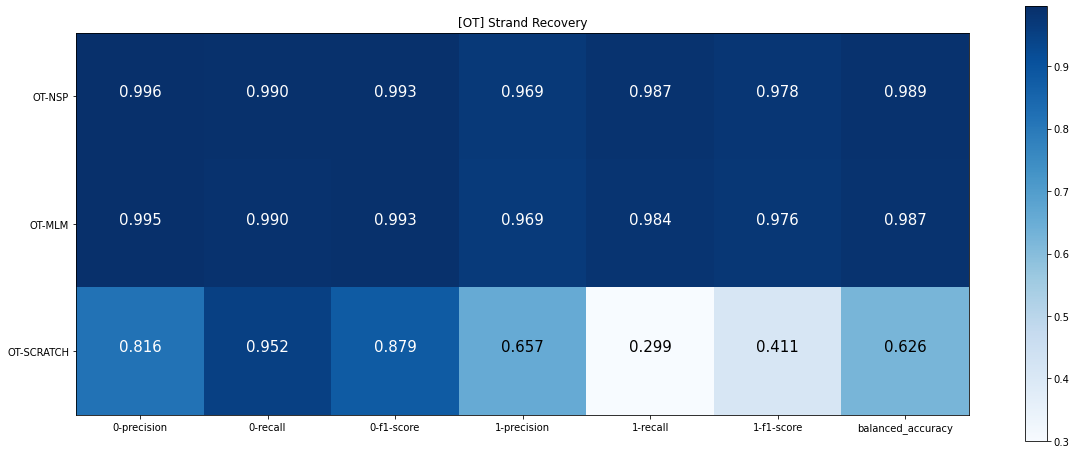

In [20]:
plot_classification_report(reports, res_dir)